In [72]:
# Polynomial Regression
import numpy as np
m = 100
X = 6*np.random.rand(m,1) - 3 # 0以上1未満の範囲で100行1列の乱数行列
y = 0.5* X**2 +X+2 +np.random.randn(m,1) # 平均が0で標準偏差が1の正規分布
X[:5]

# y = 0.5x^2 +2b
# xは -3から3

array([[ 2.56292164],
       [-2.28644527],
       [ 0.41154808],
       [ 0.98699616],
       [-1.51918613]])

Text(0, 0.5, 'y')

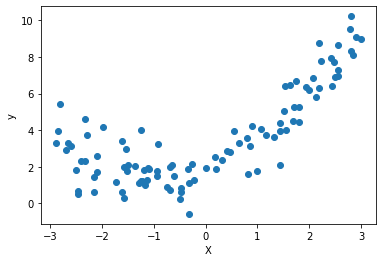

In [73]:
import matplotlib.pyplot as plt
plt.scatter(X,y)
plt.xlabel("X")
plt.ylabel("y")

In [75]:
# try Scikit-Learn's PolynomialFeatures
# when there are multiple features, this Regression can find relationships between
# features
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
# PolynomialFeatures(degree=d) transforms an array containing n features into
# (n+d)! /d!n! features
# 予め想定する次元をdegreeに入れたほうが良いだろう
# include_bias は　定数項を生成しないこと
# an array containing features
X_poly = poly_features.fit_transform(X)
X[0]

array([2.56292164])

In [76]:
X_poly[0]

# it contains its original feature and the square of it

array([2.56292164, 6.56856733])

In [77]:
# fit a Linear Regression model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_
# lin_reg.coef_ outputs [a,b]
# lin_reg.intercept_ outputs [c]
# so it estimates y = bx^2 + ax + c

(array([1.92492641]), array([[0.98169117, 0.53535679]]))

In [78]:
# how to decide whether my degree is right( not over or under fitting the data)
# use Leaning curves

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors=[],[]
    for m in range(1,len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()

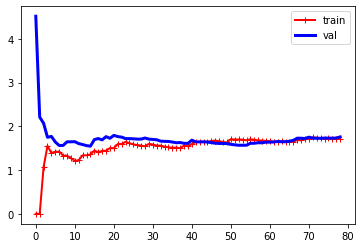

In [79]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg,X, y)

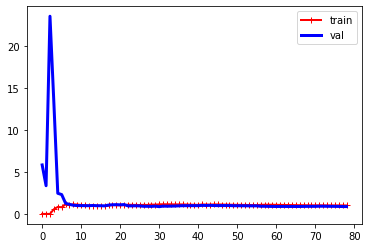

In [80]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly_features.fit_transform(X)
lin_reg = LinearRegression()
plot_learning_curves(lin_reg,X_poly, y)
# the error on the training data is much lower than with the LinearRegression model
# it performs better on the training data than on the validation data

In [81]:
# three ways to constrain the weights to reduce overfitting


In [82]:
# Ridge Regression P190

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1, solver="cholesky")
# alpha が大きいほどweightが削減され、平坦な図になり、overfittingがなくなる
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[5.18746168]])

In [83]:
# using stochastic Gradient Descent
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2")
# L2はRidge回帰を意味する
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.17584995])

In [84]:
# Lasso Regression
# alpha が大きいほどweightが削減され、平坦な図になり、overfittingがなくなる
# 二乗ではなく一乗の補正を行う、他は一緒だがalphaが増える急に平坦になる
# it tends to eliminate the weights of the least important features

from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])
# use penalty=l1 in SGDRegressor is the same

array([5.1450909])

In [85]:
# Elastic Net
# r =0  equivalent to Ridge Regression
# r=1 it is equivalent to Lasso Regression
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

# l1_ratio = r

array([5.14438026])

In [86]:
# Early stopping

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [88]:
from copy import deepcopy
from sklearn.pipeline import Pipeline
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

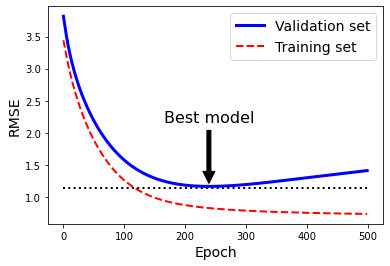

In [90]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [27]:
# Early stopping
# stop training as soon as the validation error reaches a minimum
# P197
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

#prepare the data
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                      learning_rate="constant", eta=0.0005)
minimum_val_error= float("inf")
# float("inf")は、Pythonにおける無限大（Infinity）を表す

# Note that with warm_start=True, when the fit() method is called it continues
# training where it left off, instead of restarting from scratch.
best_epoch=None
best_model=None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict=sgd_reg.predict(X_val_poly_scaled)
    if val_error<minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

NameError: name 'Pipeline' is not defined

In [91]:
# Let’s try to build a classifier to detect the Iris virginica type based only on the
# petal width feature
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

# data contains for columns 
# Sepal.Length	  Sepal.Width	  Petal.Length	  Petal.Width

# label contains one species
# 	 Species

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [92]:
set(iris["target_names"])

{'setosa', 'versicolor', 'virginica'}

In [93]:
iris["data"][:, 3:][:5] 

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2]])

In [94]:
X = iris["data"][:, 3:] # petal width

In [95]:
 y = (iris["target"] == 2).astype(np.int) # 1 if Iris virginica, else 0

C:\Users\blueb\AppData\Local\Temp\ipykernel_16044\2048123073.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int) # 1 if Iris virginica, else 0


In [96]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

In [97]:
X_new = np.linspace(0, 3, 1000).reshape(-1,1) #linspace(0, 3, 1000)
y_proba = log_reg.predict_proba(X_new)
y_proba

array([[9.99250016e-01, 7.49984089e-04],
       [9.99240201e-01, 7.59799387e-04],
       [9.99230257e-01, 7.69743043e-04],
       ...,
       [3.08374822e-03, 9.96916252e-01],
       [3.04400296e-03, 9.96955997e-01],
       [3.00476842e-03, 9.96995232e-01]])

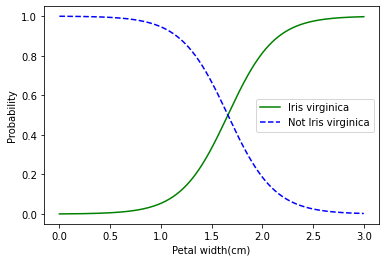

In [98]:
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica") #すべての行の列１を出す 
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")
plt.xlabel("Petal width(cm)")
plt.ylabel("Probability")
plt.legend()

In [99]:
log_reg.predict([[1.7],[1.5]])
# there is a decision boundary at around 1.6cm

array([1, 0])

In [100]:
# Softmax Regression (or Multinomial Logistic Regression)
X = iris["data"][: , (2,3)]
y = iris["target"]
softmax_reg = LogisticRegression(multi_class ="multinomial", solver="lbfgs", C=10)
# multi_class でmultinomial　を設定
# solver = "lbfgs "uses solver lbfgs to apply l2 regularization by default
# control the solver to use hyperparameter C

softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

In [101]:
softmax_reg.predict([[5,2]])

array([2])

In [102]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

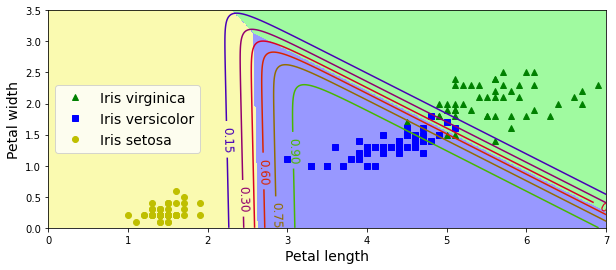

In [104]:
# decision boundary
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()